In [1]:
import requests
from PIL import Image
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import json
from datetime import datetime
from dotenv import load_dotenv
import os
import sounddevice as sd
from scipy.io.wavfile import write
import tempfile
import os
import whisper
model = whisper.load_model("base") 


In [2]:
load_dotenv() 

api_key = os.getenv("API_KEY")

In [16]:
def log_image(prompt, image_path, model_id):
    """Log image generation to history file"""
    history_file = "history.json"

    if os.path.exists(history_file):
        try:
            with open(history_file, "r") as f:
                history = json.load(f)
            if not isinstance(history, dict):
                history = {}
        except json.JSONDecodeError:
            history = {}
    else:
        history = {}

    image_entry = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "prompt": prompt,
        "model_id": model_id,
        "image_path": image_path,
    }

    history.setdefault("images", []).append(image_entry)

    with open(history_file, "w") as f:
        json.dump(history, f, indent=4)

    print(f"🖼️ Image history saved to '{history_file}'")

In [17]:
def generate_image(prompt):
    """Generate image from text prompt, display it, and save properties to JSON"""
    
    url = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"
    headers = {"Authorization": f"Bearer {API_KEY}"}
    data = {"inputs": prompt}
    
    print(f"Generating: {prompt}")
    
    response = requests.post(url, headers=headers, json=data)
    
    if response.status_code == 200:
        image_data = response.content
        
        image = Image.open(BytesIO(image_data))
        
        image_properties = {
            "prompt": prompt,
            "width": image.width,
            "height": image.height,
            "mode": image.mode,
            "format": image.format if image.format else "PNG",
            "size_bytes": len(image_data),
            "timestamp": datetime.now().isoformat(),
            "model": "stabilityai/stable-diffusion-xl-base-1.0"
        }
        
        json_filename = f"{prompt.replace(' ', '_')[:20]}_properties.json"
        with open(json_filename, 'w') as f:
            json.dump(image_properties, f, indent=2)
        
        print(f"📄 Properties saved: {json_filename}")
        
        image_filename = f"{prompt.replace(' ', '_')[:20]}.png"
        image.save(image_filename)
        print(f"💾 Image saved: {image_filename}")
        
        log_image(prompt, image_filename, "stabilityai/stable-diffusion-xl-base-1.0")
        
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off') 
        plt.title(f"Generated Image: {prompt}")
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Image generated and displayed successfully!")
        return image
    else:
        print(f"❌ Error: {response.status_code}")
        if response.status_code == 503:
             print("Model is loading, please wait and try again...")
        return None

In [18]:
def get_voice_input(duration=20, retries=2):
    for attempt in range(retries + 1):
        print(f"\n🎙️ Speak now ({duration} sec)...")
        samplerate = 44100
        recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='int16')
        sd.wait()
        print("✅ Voice input captured.")

        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as f:
            write(f.name, samplerate, recording)
            audio_path = f.name

        result = model.transcribe(audio_path)
        os.remove(audio_path)

        spoken_text = result["text"].strip().lower()
        if spoken_text:
            print(f"🗣️ You said: {spoken_text}")
            return spoken_text
        else:
            print("⚠️ Couldn't understand. Please try again.")

    print("❌ Failed to capture voice input after multiple attempts.")
    return None


🎤 Please describe the image you want to generate.

🎙️ Speak now (20 sec)...
✅ Voice input captured.


c:\Users\Naman Goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🗣️ You said: make a picture of a solar system where a red cat is sitting on the moon and a green cat sitting on the sun and they are holding hands belonging arms.

🖼️ Generating image for: 'make a picture of a solar system where a red cat is sitting on the moon and a green cat sitting on the sun and they are holding hands belonging arms.'

Generating: make a picture of a solar system where a red cat is sitting on the moon and a green cat sitting on the sun and they are holding hands belonging arms.
📄 Properties saved: make_a_picture_of_a__properties.json
💾 Image saved: make_a_picture_of_a_.png
🖼️ Image history saved to 'history.json'


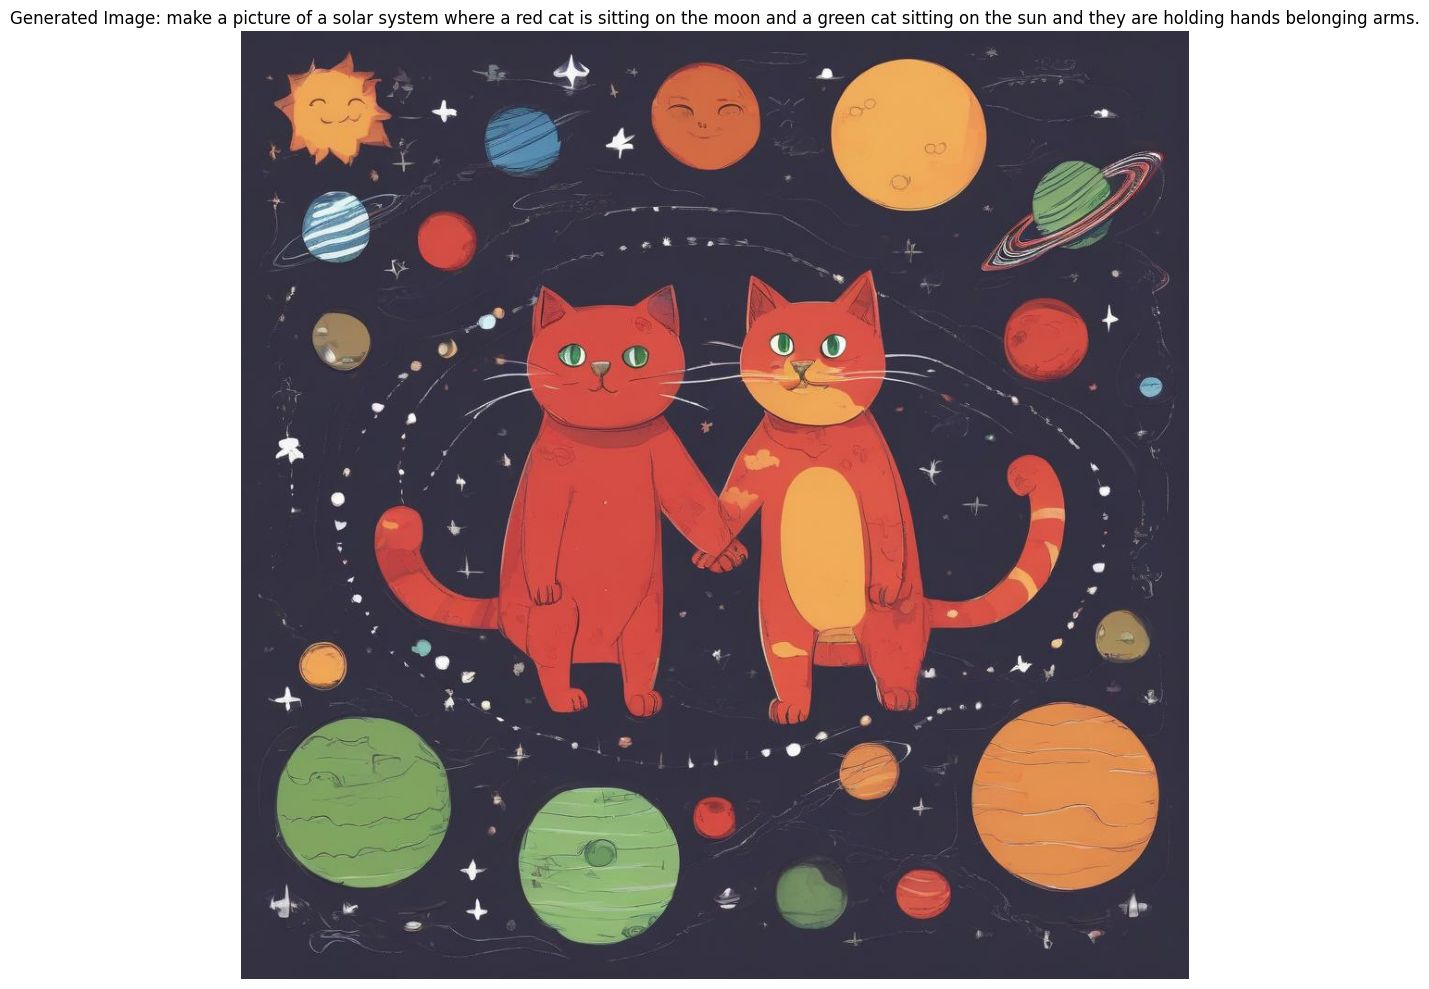

✅ Image generated and displayed successfully!


In [19]:
if __name__ == "__main__":
    print("🎤 Please describe the image you want to generate.")
    prompt = get_voice_input(duration=20)  # Adjust duration as needed

    if prompt:
        print(f"\n🖼️ Generating image for: '{prompt}'\n")
        generate_image(prompt)
    else:
        print("❌ No valid description captured. Please try again.")
